# Imports

In [4]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [5]:
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import nnpde.functions.iterative_methods as im
from nnpde.functions import geometries, helpers
from nnpde.utils.logs import enable_logging, logging 
from nnpde.problems import DirichletProblem 
from nnpde.utils import plots
import nnpde.model as M 

In [6]:
enable_logging(20)

seed = 9 # Does not give problems
torch.manual_seed(seed)
np.random.seed(seed)

2018-12-19 23:58:37,605 - root - INFO - logs - logging enabled for level: 20


# Setup

In [7]:
# Define train dimension: NxN
N = 16

# For each problem instance define number of iteration to perform to obtain the solution
nb_problem_instances = 30
problem_instances = [DirichletProblem(k=k) for k in np.random.randint(1, 20, nb_problem_instances)]

# Hyper-parameter search learning rate

In [20]:
from itertools import product
import logging

def grid_search(mdl, base_parameters, grid_search_parameters, problem_instances):
    """
    Parameters
    ==========
    
        mdl                     Model Class, 
                                expected interface: `mdl(parameters).fit(problem_instances)`
        base_parameters         dictonary of parameters which will applied for all models
        grid_search_parameters  dictonary of <parameter>: [<value for parameter key>]
        problem_instances       list of problems to train on
    """
    # the `list` is necessary if you want to print the below message
    #parameters = list(product(*grid_search_parameters.values()))
    #logging.debug('testing {} models! make sure that you have the power to run this!'.format(len(parameters)))
    # `product` is equivalent to a nested for loop
    parameters = product(*grid_search_parameters.values())

    # the dict(zip(...)) part is necessary to ensure correct assignment
    res = [mdl(**{**base_parameters, **dict(zip(grid_search_parameters.keys(), p))}).fit(problem_instances) for p in parameters]
    return res

In [21]:
def grid_search_wrapper(base_parameters, grid_search_parameters):
    return grid_search(mdl=M.JacobyWithConv,
                       base_parameters=base_parameters,
                       grid_search_parameters=grid_search_parameters,
                       problem_instances=problem_instances)

In [23]:
reload(M)

# Took 3m 13s on a Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz

# Net parameters
base_parameters = {
    "nb_layers": 3,
    "max_epochs": 100,
    "batch_size": 10,
    "stable_count": 10,
    "random_seed": 9
}

# SGD
grid_parameters = {
    "learning_rate": np.logspace(start=-6, stop=-4, num=7), #num=7 is good since it contains 1e-5
}
hyper_models = grid_search_wrapper(base_parameters, grid_parameters) \
    + grid_search_wrapper(base_parameters, {"optimizer": ["Adadelta"]})

2018-12-20 00:51:14,720 - root - INFO - model - Training with max_epochs: 100, tol: 0.0001. Initial loss is 1641.115478515625
2018-12-20 00:51:15,903 - root - INFO - model - iter 0 with total loss 1050.2430419921875
2018-12-20 00:51:26,836 - root - INFO - model - Convergence reached in 10 epochs with total loss 808.0904541015625
2018-12-20 00:51:27,101 - root - INFO - model - Training with max_epochs: 100, tol: 0.0001. Initial loss is 1641.115478515625
2018-12-20 00:51:28,141 - root - INFO - model - iter 0 with total loss 922.9979248046875
2018-12-20 00:51:37,660 - root - INFO - model - Convergence reached in 10 epochs with total loss 767.71240234375
2018-12-20 00:51:37,881 - root - INFO - model - Training with max_epochs: 100, tol: 0.0001. Initial loss is 1641.115478515625
2018-12-20 00:51:38,854 - root - INFO - model - iter 0 with total loss 831.3388671875
2018-12-20 00:51:48,988 - root - INFO - model - Convergence reached in 10 epochs with total loss 735.4732055664062
2018-12-20 00:

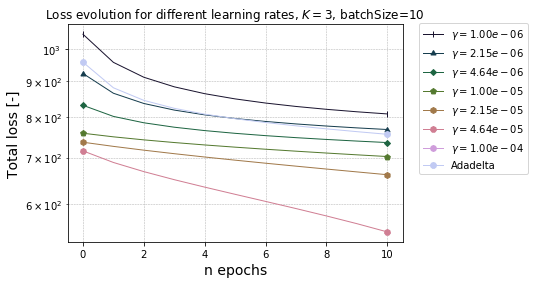

In [24]:
# Colors for plotting
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

# Initilize figure
hyper_fig = plt.figure()

# Plot SGD
i = 0
for model in hyper_models[:-1]:  
    n_epoch = np.arange(np.shape(model.losses)[0])
    plt.semilogy(n_epoch, 
                 model.losses, 
                 color=colors[i], 
                 linewidth=1, 
                 linestyle="-", 
                 marker=(i+2, 0, 0), 
                 markevery=10, 
                 label = f'$\gamma= {learning_rates[i]:.2e} $')
    i += 1

# Plot Adadelta
n_epoch = np.arange(np.shape(hyper_models[-1].losses)[0])
plt.semilogy(n_epoch, hyper_models[-1].losses, color=colors[i], linewidth=1, linestyle="-", marker=(i+2, 0, 0), markevery=10,label='Adadelta')

# Additional settings
plt.legend(bbox_to_anchor=(1.05, 0.31), loc=3, borderaxespad=0.)
plt.xlabel('n epochs', fontsize=14)
plt.ylabel('Total loss [-]', fontsize=14)
#plt.xlim([0, base_parameters['max_epochs']])
#plt.ylim([0, 200])
plt.title('Loss evolution for different learning rates, $K=3$, batchSize=10')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

#hyper_fig.savefig('../report/fig/hyper.eps', bbox_inches='tight')
plt.draw()
plt.show()

# Train model using K = 1,2,3,4,5

In [26]:
base_parameters

{'nb_layers': 3,
 'max_epochs': 100,
 'batch_size': 10,
 'stable_count': 10,
 'random_seed': 9}

In [29]:
reload(M)

params = {**base_parameters, **{'max_epochs': 200, 'optimizer': 'Adadelta'}}
models = grid_search_wrapper(params, {'nb_layers': range(1, 6)})

#models = [M.JacobyWithConv(**{**params, 'nb_layers': nb_layers}).fit(problem_instances) for nb_layers in [1,2,3,4,5]]

2018-12-20 01:04:04,276 - root - INFO - model - Using optimizer Adadelta
2018-12-20 01:04:04,474 - root - INFO - model - Training with max_epochs: 200, tol: 0.0001. Initial loss is 13326.283203125
2018-12-20 01:04:05,286 - root - INFO - model - iter 0 with total loss 3609.199462890625
2018-12-20 01:04:12,375 - root - INFO - model - Convergence reached in 10 epochs with total loss 837.144287109375
2018-12-20 01:04:12,377 - root - INFO - model - Using optimizer Adadelta
2018-12-20 01:04:12,567 - root - INFO - model - Training with max_epochs: 200, tol: 0.0001. Initial loss is 511491.90625
2018-12-20 01:04:13,299 - root - INFO - model - iter 0 with total loss 71287.515625
2018-12-20 01:04:21,665 - root - INFO - model - Convergence reached in 10 epochs with total loss 8135.30859375
2018-12-20 01:04:21,667 - root - INFO - model - Using optimizer Adadelta
2018-12-20 01:04:21,904 - root - INFO - model - Training with max_epochs: 200, tol: 0.0001. Initial loss is 1641.115478515625
2018-12-20 0

For K=1 final loss is 837.144287109375
For K=2 final loss is 8135.30859375
For K=3 final loss is 755.718994140625
For K=4 final loss is 357.1276550292969
For K=5 final loss is 515.855712890625


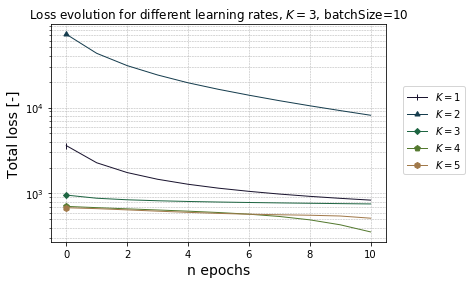

In [33]:
# Colors for plotting
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

# Initilize figure
comparison_K_fig = plt.figure()

# Plot SGD
i = 0
for model in models[:]:  
    n_epoch = np.arange(np.shape(model.losses)[0])
    plt.semilogy(n_epoch, model.losses, color=colors[i], linewidth=1, linestyle="-", marker=(i+2, 0, 0), markevery=100, label = '$K= {0} $'.format(model.nb_layers))
    print("For K={0} final loss is {1}".format(model.nb_layers, model.losses[-1]))
    i += 1

# Additional settings
plt.legend(bbox_to_anchor=(1.05, 0.31), loc=3, borderaxespad=0.)
plt.xlabel('n epochs', fontsize=14)
plt.ylabel('Total loss [-]', fontsize=14)
#plt.xlim([0, max_epochs])
#plt.ylim([0, 800])
plt.title('Loss evolution for different learning rates, $K=3$, batchSize=10')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

#hyper_fig.savefig('../report/fig/comparison_K.eps', bbox_inches='tight')
plt.draw()
plt.show()

In [ ]:
models[1].max_epochs = 300
models[1].fit(problem_instances)

# Test on a bigger grid

In [ ]:
from nnpde.metrics import least_squares_loss as LSE

In [ ]:
# Grid size NxN
N = 64

# Use sufficiently high number of iterations to get ground truth solution
k_ground_truth = 20000

# Initialize Laplace problem on Square geometry
problem = DirichletProblem(N=N, k_ground_truth=20000)
B_idx = problem.B_idx
B = problem.B
f = problem.f

# Obtain solutions
ground_truth = problem.ground_truth

# Set initial_u equal for Jacobi method and for H method
initial_u = torch.ones(1,1,N,N)
k = 2000

# Obtain solution with Jacobi method
u_jacobi = im.jacobi_method(B_idx, B, f, initial_u, k = 2000)
print(f"Error after {k} iterations for Jacobi method: {LSE(ground_truth, u_jacobi)}")

# For each K obtain 
for model in models:
    u_H = im.H_method(model.net, B_idx, B, f, initial_u, k = 2000)
    print(f"Error after {k} iterations for H method with K={model.nb_layers}: {LSE(ground_truth, u_H)}")

# Error evolution with iterations

In [ ]:
tol = 1e-6
net = models[2].net

In [ ]:
u_jacobi = initial_u
err_jacobi = LSE(ground_truth, u_jacobi).item()
errs_jacobi = [err_jacobi] 
k_jacobi = 0

while err_jacobi >= tol:
    u_jacobi = im.jacobi_method(B_idx, B, f, u_jacobi, k = 1)
    err_jacobi = LSE(ground_truth, u_jacobi).item()
    errs_jacobi.append(err_jacobi)
    k_jacobi += 1
    
print(f"Jacobi method: error of {err_to_be_achieved} achieved after {k_jacobi} iterations.")

In [ ]:
errors_H = []
max_iters = 10000

for model in models:
    u_H = initial_u
    err_H = LSE(ground_truth, u_H).item()
    errs_H = [err_H] 
    k_H = 0

    while err_H >= tol:
        u_H = im.H_method(model.net, B_idx, B, f, u_H, k = 1)
        err_H = LSE(ground_truth, u_H).item()
        errs_H.append(err_H)
        k_H += 1
        if k_H > max_iters or err_H == np.inf:
            print(f"H method, K = {model.nb_layers}: convergence not reached after {max_iters}, final error is {err_H}.")
            break
    
    print(f"H method, K = {model.nb_layers}: error of {err_to_be_achieved} achieved after {k_H} iterations.")
    errors_H.append(errs_H)

In [ ]:
# Colors for plotting
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

# Initilize figure
error_k_fig = plt.figure()

i = 0
for error in errors_H:  
    n_iter = np.arange(np.shape(error)[0])
    plt.loglog(n_iter, error, color=colors[i], linewidth=1, linestyle="-", marker=(i+2, 0, 0), markevery=100, label = '$K= {0} $'.format(models[i].nb_layers))
    i += 1

# Plot error evolution for Jacobi 
n_iter = np.arange(np.shape(errs_jacobi)[0])
plt.loglog(n_iter, errs_jacobi, color=colors[i], linewidth=1, linestyle="-", marker=(i+2, 0, 0), markevery=1000, label = 'Jacobi')

# Additional settings
plt.legend(bbox_to_anchor=(1.05, 0.31), loc=3, borderaxespad=0.)
plt.xlabel('n iterations', fontsize=14)
plt.ylabel('Error [-]', fontsize=14)
#plt.xlim([0, max_epochs])
plt.ylim([tol, errors_H[0][0]])
plt.title('Error evolution for different $K$, $N={0}$'.format(N))
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

#error_k_fig.savefig('../report/fig/error_k.eps', bbox_inches='tight')
plt.draw()
plt.show()

In [ ]:
# This is not correct, but we have to look for a way to access the variables inside timeit

print("needed {0} iterations (compared to {1}), ratio: {2}".format(k_count_old, k_count_new, k_count_old/k_count_new))

In [ ]:
print("the loss of the new method is {0}, compared to the pure-jacoby one: {1}. computed with {2} iterations".format(F.mse_loss(gtt, output), F.mse_loss(gtt, jacoby_pure), nb_iters))

In [ ]:
helpers.plot_solution(gtt,output,N)

In [ ]:
(gtt.view(N,N) - output.view(N,N)).mean()

Test on L-shape domain

In [ ]:
B_idx, B = geometries.l_shaped_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(net, B_idx, B, f, torch.ones(1,1,N,N), k = 2000)

In [ ]:
helpers.plot_solution(gtt,output,N)

In [ ]:
compare_flops(16,k_count_new,k_count_old,3)

In [ ]:
Spectral radius. Don't remove Francesco will delete me

In [ ]:
B_idx = problem_instances[1].B_idx
net = nn.Sequential(nn.Conv2d(1, 1, 3, padding=1, bias=False))
G = helpers.build_G(B_idx)
T = helpers.build_T(N)
H = helpers.conv_net_to_matrix(net, N)
I = np.eye(N)
helpers.spectral_radius(T+G.dot(H).dot(T)-G.dot(H))

# model testing

In [47]:
import nnpde.model_testing as MT
reload(MT)

<module 'nnpde.model_testing' from '/home/sam/proj/epfl/ml_pde_solver/nnpde/nnpde/model_testing.py'>

In [39]:
mdl = M.JacobyWithConv(**base_parameters).fit(problem_instances)

2018-12-20 01:12:28,287 - root - INFO - model - Training with max_epochs: 100, tol: 0.0001. Initial loss is 1641.115478515625
2018-12-20 01:12:29,548 - root - INFO - model - iter 0 with total loss 1050.2430419921875
2018-12-20 01:12:42,006 - root - INFO - model - Convergence reached in 10 epochs with total loss 808.0904541015625


In [41]:
test_results =  list(MT.test_model(mdl.net, 1, 64))

In [48]:
test_results = MT.test_results_pd(mdl.net, 10, 64)

In [49]:
test_results

,nb solver,nb_conv_solver,flops_ratio
0,100001,2703,0.387165
1,100001,2711,0.388311
2,100001,2729,0.390889
3,100001,2716,0.389027
4,100001,2701,0.386878
5,100001,2740,0.392464
6,100001,2755,0.394613
7,100001,2716,0.389027
8,100001,2704,0.387308
9,100001,2706,0.387594
